In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision import transforms
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Dataset, dataloader

In [2]:
class MyDataset(Dataset):
    def __init__(self, img_dir, train=True, transform=None, target_transform=None):
        self.img_dir = img_dir
        if train:
            self.img_paths = os.listdir(img_dir)[:4000]
        else:
            self.img_paths = os.listdir(img_dir)[4000:]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        path = os.path.join(self.img_dir, self.img_paths[index])
        image = read_image(path) / 255
        random_illuminant = np.random.rand(3)
        image = np.multiply(image, random_illuminant[:, None, None])
        if self.transform:
            image = self.transform(image)
        return image.to(torch.float32), random_illuminant

In [3]:
img_dir = r"C:\Users\dranh\Desktop\fivek-dataset\export\experta_small"

my_transforms = transforms.Compose([
    transforms.Resize((128, 128))
])

train_dataloader = DataLoader(MyDataset(img_dir, train=True, transform=my_transforms), 64, shuffle=True)
test_dataloader = DataLoader(MyDataset(img_dir, train=False, transform=my_transforms), 64, shuffle=True)

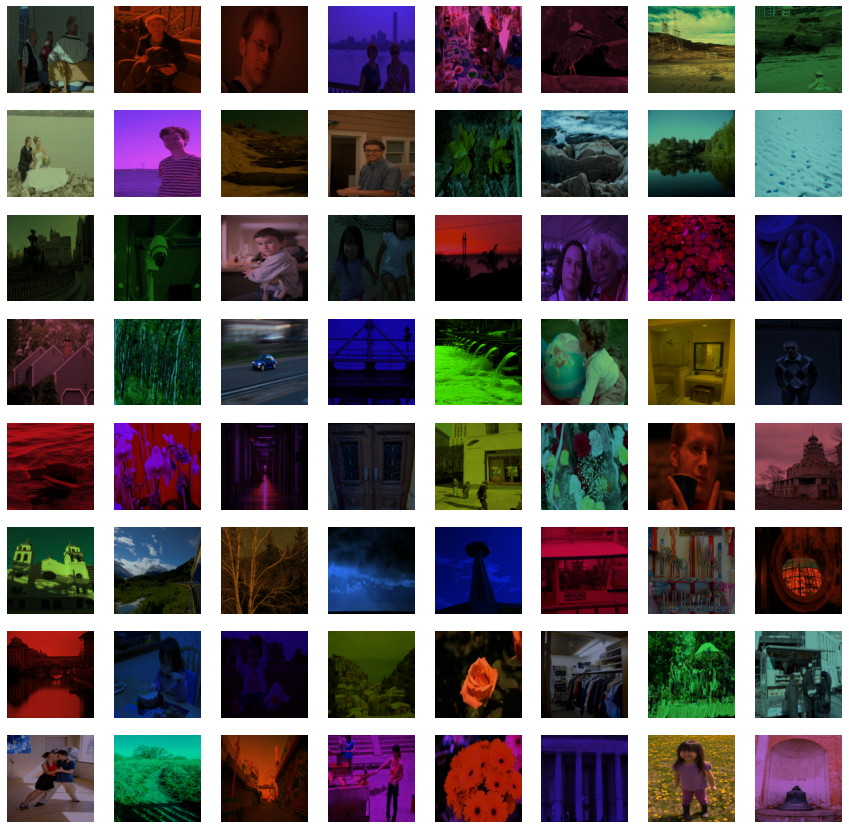

In [4]:
# Show batch
plt.figure(figsize=(15, 15))
images, labels = next(iter(train_dataloader))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = torch.permute(images[i], (1, 2, 0))
    plt.imshow(image)
    plt.axis("off")

# Estimate-Color Network

In [4]:
class EstimateColorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(24, 48, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(48, 96, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(96, 192, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.lastblock = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*192, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.lastblock(x)
        return x

    

In [5]:
device = 'cuda'
model = EstimateColorNetwork().to(device)

# Criterion, optimizer

In [6]:
def loss_fn(outputs, targets):
    return torch.arccos(torch.cosine_similarity(outputs, targets)).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train

In [46]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter('runs/EstimateColor_{}'.format(timestamp))
n_epochs = 60

def train_one_epoch(epoch_index):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    writer.flush()
    return last_loss

def validation():
    running_loss = 0.0
    for i, data in enumerate(test_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
    avg_loss = running_loss / (i + 1)
    return avg_loss

for epoch_index in range(n_epochs):
    print('EPOCH {}:'.format(epoch_index))

    model.train(True)
    train_loss = train_one_epoch(epoch_index)
    model.train(False)
    val_loss = validation()

    print('LOSS train {} valid {}'.format(train_loss, val_loss))
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : train_loss, 'Validation' : val_loss },
                    epoch_index + 1)
    writer.flush()


EPOCH 0:
  batch 10 loss: 0.43208393497627745
  batch 20 loss: 0.4308835851380044
  batch 30 loss: 0.41248197113731777
  batch 40 loss: 0.4292878781980868
  batch 50 loss: 0.43409196628086305
  batch 60 loss: 0.4249841438282275
LOSS train 0.4249841438282275 valid 0.42501692381812767
EPOCH 1:
  batch 10 loss: 0.4254967207201242
  batch 20 loss: 0.42717056798472
  batch 30 loss: 0.4186255526968778
  batch 40 loss: 0.42541101807816073
  batch 50 loss: 0.4349496640122605
  batch 60 loss: 0.4332150766189181
LOSS train 0.4332150766189181 valid 0.4219043069804222
EPOCH 2:
  batch 10 loss: 0.43529250909048967
  batch 20 loss: 0.4329339216749619
  batch 30 loss: 0.4243096133943488
  batch 40 loss: 0.414962674491386
  batch 50 loss: 0.41327711710112947
  batch 60 loss: 0.4122739827203876
LOSS train 0.4122739827203876 valid 0.3883643509932834
EPOCH 3:
  batch 10 loss: 0.38577499596619824
  batch 20 loss: 0.35802420803830043
  batch 30 loss: 0.33353638256267726
  batch 40 loss: 0.3400586273353462


# Save & load

In [47]:
model_path = 'checkpoints/model_{}.pth'.format(timestamp)
torch.save(model.state_dict(), model_path)
print("Saved " + model_path)

In [33]:
model = EstimateColorNetwork()
model.load_state_dict(torch.load("checkpoints/model_20220822_170814.pth"))
model.eval()

EstimateColorNetwork(
  (block1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


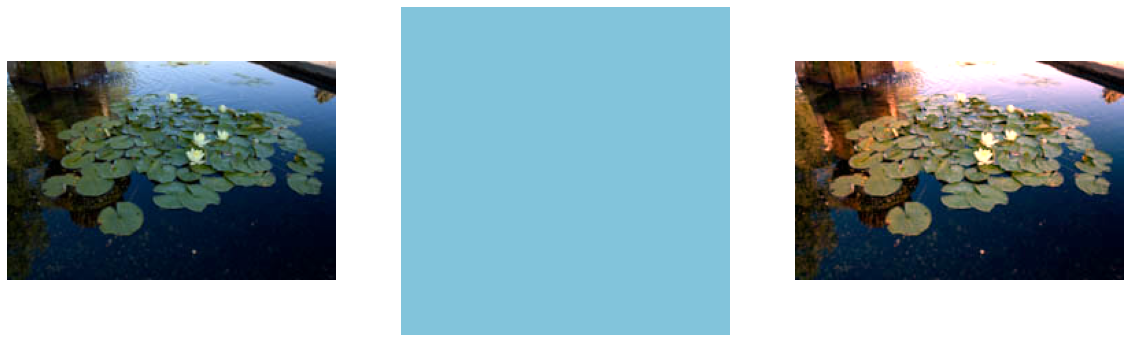

In [84]:
def infer(image_path):
    image = read_image(image_path) / 255
    if my_transforms:
        input = my_transforms(image).to(torch.float32)
    input = torch.unsqueeze(input, 0)
    with torch.no_grad():
        output = model(input)
    color = output[0]
    image_out = np.divide(image, color[:, None, None])

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(torch.permute(image, (1,2,0)))
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    image_width = image.shape[1]
    color_bar = np.ndarray((9, 9, 3))
    color_bar[:,:] = color
    plt.imshow(color_bar)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(torch.permute(image_out, (1,2,0)))
    plt.axis("off")




infer(r"C:\Users\dranh\Desktop\fivek-dataset\export\experta_small\a0004-jmac_MG_1384.jpg")
# infer('images/landscape-4175978_960_720.jpg')
# infer(r"images/NikonD5200_Indoor_Scene_18_6500_T_V.jpg")
# infer(r"C:\Users\dranh\Desktop\nikon\NikonD5200_Indoor_Scene_18_6500_C_AS.jpg")
# infer(r"images\test_image.png")